In [316]:
%load_ext autoreload
%load_ext tensorboard
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [28]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import nltk # just for tokenization
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import random
import gradio 
import string
import tensorflow as tf
import datetime

random.seed(42)

c:\Users\shivs\anaconda3\envs\chess-engine\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [29]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("word2vec-google-news-300")
    print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))
    return wv_from_bin
wv_from_bin = load_embedding_model()
# wv_from_bin = load_embedding_model()

Loaded vocab size 3000000


In [30]:
benchmark_df = pd.read_csv("../../data/million_songs.csv")
benchmark_df.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [31]:
def tokenize(lyric: str) -> list[str]:
    # lowercase the text, remove stop words, punctuation and keep only the words
    lyric.replace("<br>", "\n")
    tokens = nltk.tokenize.word_tokenize(lyric.lower())
    stop_words = stopwords.words("english") + list(string.punctuation)
    lemmatizer = WordNetLemmatizer()
    alpha_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token not in stop_words]

    return alpha_tokens

In [32]:
def vectorise(lyrics: str) -> np.ndarray:
    tokens = tokenize(lyrics)
    lyric_vector = np.zeros(300)
    for token in tokens:
        try:
            lyric_vector += wv_from_bin.get_vector(token.lower())
        except:
            continue
    return lyric_vector / np.linalg.norm(lyric_vector)

In [33]:
# go through each lyrics, tokenize it, vectorize each word, then combine all of them into single average vector and store it in the list

def get_embeddings(lyrics):
    lyrics_embeddings = []
    unsupported_tokens = set()
    label_embedding_map = {} # dict{str: np.array([])}
    for lyric in tqdm(lyrics):
        lyric_vector = np.zeros(300)
        for token in tokenize(lyric):
            try:
                lyric_vector += wv_from_bin.get_vector(token.lower())
            except KeyError as e:
                # if the word is not present in the glove then key error is raised, so handle the exception and move on
                unsupported_tokens.add(token)
                continue
        lyrics_embeddings.append(lyric_vector)


    lyrics_embeddings = np.stack(lyrics_embeddings)
    scaled_lyrics_embeddings = lyrics_embeddings / np.linalg.norm(lyrics_embeddings, axis=1, keepdims=True)
    return scaled_lyrics_embeddings

In [34]:
train_embeddings = get_embeddings(benchmark_df["text"])

  0%|          | 0/57650 [00:00<?, ?it/s]

100%|██████████| 57650/57650 [02:25<00:00, 395.20it/s]


In [35]:
def distance(metric: str, embedding_matrix: np.ndarray, test_vector: np.ndarray) -> np.ndarray:
    if metric == "cosine":
            
        dot_product = np.dot(embedding_matrix, test_vector)

        # Compute magnitudes
        embedding_magnitudes = np.linalg.norm(embedding_matrix, axis=1)
        test_vector_magnitude = np.linalg.norm(test_vector)

        # Compute cosine similarity
        cosine_similarity = dot_product / (embedding_magnitudes * test_vector_magnitude)
        return cosine_similarity
    elif metric == "euclidean":
        distances = np.linalg.norm(scaled_lyrics_embeddings - test_vector, axis=1)
        return distances
    else:
        raise Exception(f"Invalid parameter value {metric}")

In [36]:
def cosine_distance(X, centroids):
    # Compute cosine similarity between each data point and each centroid
    dot_product = np.dot(X, centroids.T)
    norms_X = np.linalg.norm(X, axis=1)[:, np.newaxis]
    norms_centroids = np.linalg.norm(centroids, axis=1)
    cosine_similarities = dot_product / (norms_X * norms_centroids)
    
    # Convert cosine similarities to cosine distances
    cosine_distances = 1 - cosine_similarities
    
    return cosine_distances

In [37]:
def within_cluster_sum_of_squares(X, labels, centers):
    wcss = 0
    for i in range(len(centers)):
        cluster_points = X[labels == i]
        wcss += np.sum(cosine_distance(cluster_points, centers[i][None, :])**2)
    return wcss

In [38]:
import numpy as np

def kmeans(X, centroids, max_iterations=100):
    log_folder = "logs/kmeans/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    summary_writer = tf.summary.create_file_writer(log_folder)
    with summary_writer.as_default():
        tf.summary.text("K centeroids", str(centroids), step=0)
        
    for epoch in tqdm(range(max_iterations)):
        # Assign each data point to the nearest centroid
        distances = cosine_distance(X, centroids)  # Calculate distances
        labels = np.argmin(distances, axis=1)  # Assign labels
       
        # Update centroids
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(centroids.shape[0])])
        
        # Check for convergence
        if np.all(centroids == new_centroids):
            break
        
        centroids = new_centroids
        wcss = within_cluster_sum_of_squares(X, labels=labels, centers=centroids)
        print(f"epoch {epoch}, WCSS {wcss}")
        with summary_writer.as_default():
            tf.summary.scalar("WCSS", wcss, step=epoch)
        
    
    return labels, centroids



In [39]:

initial_centroids = train_embeddings[np.random.choice(train_embeddings.shape[0], 9, replace=False)]
# Perform K-means clustering
labels, centroids = kmeans(train_embeddings,initial_centroids, max_iterations=100)

print("Cluster centroids:", centroids)
print("Cluster labels:", labels)


  1%|          | 1/100 [00:00<00:36,  2.75it/s]

epoch 0, WCSS 1260.5832057751347


  2%|▏         | 2/100 [00:00<00:36,  2.71it/s]

epoch 1, WCSS 1056.3469960258199


  3%|▎         | 3/100 [00:01<00:34,  2.80it/s]

epoch 2, WCSS 1015.2356056582853


  4%|▍         | 4/100 [00:01<00:34,  2.81it/s]

epoch 3, WCSS 991.9385037776981


  5%|▌         | 5/100 [00:01<00:33,  2.84it/s]

epoch 4, WCSS 978.6533851356276


  6%|▌         | 6/100 [00:02<00:33,  2.78it/s]

epoch 5, WCSS 971.0465475683061


  7%|▋         | 7/100 [00:02<00:33,  2.81it/s]

epoch 6, WCSS 966.3478584883037


  8%|▊         | 8/100 [00:02<00:31,  2.94it/s]

epoch 7, WCSS 963.1153829753166


  9%|▉         | 9/100 [00:03<00:29,  3.11it/s]

epoch 8, WCSS 960.9369320190355


 10%|█         | 10/100 [00:03<00:27,  3.22it/s]

epoch 9, WCSS 959.4316190706298


 11%|█         | 11/100 [00:03<00:27,  3.23it/s]

epoch 10, WCSS 958.4594875276848


 12%|█▏        | 12/100 [00:03<00:26,  3.27it/s]

epoch 11, WCSS 957.8040600015377


 13%|█▎        | 13/100 [00:04<00:26,  3.31it/s]

epoch 12, WCSS 957.3269924468182


 14%|█▍        | 14/100 [00:04<00:25,  3.36it/s]

epoch 13, WCSS 956.943273638281


 15%|█▌        | 15/100 [00:04<00:25,  3.38it/s]

epoch 14, WCSS 956.6810546208044


 16%|█▌        | 16/100 [00:05<00:24,  3.42it/s]

epoch 15, WCSS 956.4425048786449


 17%|█▋        | 17/100 [00:05<00:24,  3.33it/s]

epoch 16, WCSS 956.2753489823656


 18%|█▊        | 18/100 [00:05<00:24,  3.30it/s]

epoch 17, WCSS 956.1576734730892


 19%|█▉        | 19/100 [00:06<00:24,  3.30it/s]

epoch 18, WCSS 956.0207659617507


 20%|██        | 20/100 [00:06<00:24,  3.29it/s]

epoch 19, WCSS 955.8989376268936


 21%|██        | 21/100 [00:06<00:24,  3.17it/s]

epoch 20, WCSS 955.7841679452657


 22%|██▏       | 22/100 [00:07<00:24,  3.16it/s]

epoch 21, WCSS 955.6705907924813


 23%|██▎       | 23/100 [00:07<00:25,  3.02it/s]

epoch 22, WCSS 955.5517912488154


 24%|██▍       | 24/100 [00:07<00:25,  3.03it/s]

epoch 23, WCSS 955.4462540204645


 25%|██▌       | 25/100 [00:08<00:24,  3.02it/s]

epoch 24, WCSS 955.3171769419266


 26%|██▌       | 26/100 [00:08<00:24,  2.99it/s]

epoch 25, WCSS 955.197429414877


 27%|██▋       | 27/100 [00:08<00:24,  2.99it/s]

epoch 26, WCSS 955.0604660464819


 28%|██▊       | 28/100 [00:09<00:24,  2.99it/s]

epoch 27, WCSS 954.9451926576014


 29%|██▉       | 29/100 [00:09<00:24,  2.94it/s]

epoch 28, WCSS 954.8397814224721


 30%|███       | 30/100 [00:09<00:23,  2.96it/s]

epoch 29, WCSS 954.6815959524401


 31%|███       | 31/100 [00:10<00:22,  3.05it/s]

epoch 30, WCSS 954.5565779472139


 32%|███▏      | 32/100 [00:10<00:21,  3.12it/s]

epoch 31, WCSS 954.430839995081


 33%|███▎      | 33/100 [00:10<00:21,  3.18it/s]

epoch 32, WCSS 954.3234078656021


 34%|███▍      | 34/100 [00:10<00:20,  3.26it/s]

epoch 33, WCSS 954.2218510760182


 35%|███▌      | 35/100 [00:11<00:19,  3.34it/s]

epoch 34, WCSS 954.1416348485554


 36%|███▌      | 36/100 [00:11<00:18,  3.40it/s]

epoch 35, WCSS 954.0651128310108


 37%|███▋      | 37/100 [00:11<00:18,  3.39it/s]

epoch 36, WCSS 954.0124469143738


 38%|███▊      | 38/100 [00:12<00:18,  3.28it/s]

epoch 37, WCSS 953.9458533018086


 39%|███▉      | 39/100 [00:12<00:18,  3.39it/s]

epoch 38, WCSS 953.8914399300102


 40%|████      | 40/100 [00:12<00:17,  3.49it/s]

epoch 39, WCSS 953.8574789811038


 41%|████      | 41/100 [00:12<00:16,  3.53it/s]

epoch 40, WCSS 953.8269820811814


 42%|████▏     | 42/100 [00:13<00:17,  3.37it/s]

epoch 41, WCSS 953.8191792151672


 43%|████▎     | 43/100 [00:13<00:16,  3.43it/s]

epoch 42, WCSS 953.8129711706999


 44%|████▍     | 44/100 [00:13<00:16,  3.39it/s]

epoch 43, WCSS 953.8164052933641


 45%|████▌     | 45/100 [00:14<00:16,  3.33it/s]

epoch 44, WCSS 953.8107355737669


 46%|████▌     | 46/100 [00:14<00:16,  3.24it/s]

epoch 45, WCSS 953.8096404500396


 47%|████▋     | 47/100 [00:14<00:15,  3.31it/s]

epoch 46, WCSS 953.8022089195911


 48%|████▊     | 48/100 [00:15<00:15,  3.37it/s]

epoch 47, WCSS 953.7924743554086


 49%|████▉     | 49/100 [00:15<00:14,  3.42it/s]

epoch 48, WCSS 953.7892261454565


 50%|█████     | 50/100 [00:15<00:14,  3.38it/s]

epoch 49, WCSS 953.790840167574


 51%|█████     | 51/100 [00:16<00:15,  3.24it/s]

epoch 50, WCSS 953.7895873840572


 52%|█████▏    | 52/100 [00:16<00:15,  3.10it/s]

epoch 51, WCSS 953.7927277336389


 53%|█████▎    | 53/100 [00:16<00:14,  3.16it/s]

epoch 52, WCSS 953.788883299629


 54%|█████▍    | 54/100 [00:16<00:14,  3.15it/s]

epoch 53, WCSS 953.7871186958483


 55%|█████▌    | 55/100 [00:17<00:14,  3.09it/s]

epoch 54, WCSS 953.783601649234


 56%|█████▌    | 56/100 [00:17<00:13,  3.20it/s]

epoch 55, WCSS 953.7897765797336


 57%|█████▋    | 57/100 [00:17<00:13,  3.24it/s]

epoch 56, WCSS 953.7881948384619


 58%|█████▊    | 58/100 [00:18<00:13,  3.21it/s]

epoch 57, WCSS 953.7880161822438


 59%|█████▉    | 59/100 [00:18<00:12,  3.24it/s]

epoch 58, WCSS 953.786793352085


 60%|██████    | 60/100 [00:18<00:11,  3.34it/s]

epoch 59, WCSS 953.7875832645332


 61%|██████    | 61/100 [00:19<00:11,  3.38it/s]

epoch 60, WCSS 953.7910576522362


 62%|██████▏   | 62/100 [00:19<00:11,  3.36it/s]

epoch 61, WCSS 953.7889185109274


 63%|██████▎   | 63/100 [00:19<00:10,  3.41it/s]

epoch 62, WCSS 953.7856983530163


 64%|██████▍   | 64/100 [00:19<00:10,  3.40it/s]

epoch 63, WCSS 953.781336461893


 65%|██████▌   | 65/100 [00:20<00:10,  3.36it/s]

epoch 64, WCSS 953.776960212054


 66%|██████▌   | 66/100 [00:20<00:10,  3.37it/s]

epoch 65, WCSS 953.775629858093


 67%|██████▋   | 67/100 [00:20<00:09,  3.45it/s]

epoch 66, WCSS 953.7762209219836


 68%|██████▊   | 68/100 [00:21<00:09,  3.43it/s]

epoch 67, WCSS 953.78670089956


 69%|██████▉   | 69/100 [00:21<00:09,  3.41it/s]

epoch 68, WCSS 953.7868717908945


 70%|███████   | 70/100 [00:21<00:08,  3.44it/s]

epoch 69, WCSS 953.7876320652422


 71%|███████   | 71/100 [00:22<00:08,  3.49it/s]

epoch 70, WCSS 953.785831693312


 72%|███████▏  | 72/100 [00:22<00:08,  3.38it/s]

epoch 71, WCSS 953.7914005732699


 73%|███████▎  | 73/100 [00:22<00:08,  3.37it/s]

epoch 72, WCSS 953.7899057242772


 74%|███████▍  | 74/100 [00:22<00:07,  3.42it/s]

epoch 73, WCSS 953.7871065847135


 75%|███████▌  | 75/100 [00:23<00:07,  3.48it/s]

epoch 74, WCSS 953.7849058195771


 76%|███████▌  | 76/100 [00:23<00:07,  3.35it/s]

epoch 75, WCSS 953.7697373867643


 77%|███████▋  | 77/100 [00:23<00:07,  2.98it/s]

epoch 76, WCSS 953.7553676141089


 78%|███████▊  | 78/100 [00:24<00:08,  2.73it/s]

epoch 77, WCSS 953.7532172993173


 79%|███████▉  | 79/100 [00:24<00:07,  2.73it/s]

epoch 78, WCSS 953.7513404507616


 80%|████████  | 80/100 [00:25<00:07,  2.84it/s]

epoch 79, WCSS 953.748195315584


 81%|████████  | 81/100 [00:25<00:06,  2.81it/s]

epoch 80, WCSS 953.7478121008322


 82%|████████▏ | 82/100 [00:25<00:06,  2.79it/s]

epoch 81, WCSS 953.7626356565398


 83%|████████▎ | 83/100 [00:26<00:05,  2.85it/s]

epoch 82, WCSS 953.7731686155627


 84%|████████▍ | 84/100 [00:26<00:05,  2.70it/s]

epoch 83, WCSS 953.7778634738396


 85%|████████▌ | 85/100 [00:26<00:05,  2.65it/s]

epoch 84, WCSS 953.7796539100037


 86%|████████▌ | 86/100 [00:27<00:05,  2.59it/s]

epoch 85, WCSS 953.7885812464385


 87%|████████▋ | 87/100 [00:27<00:04,  2.62it/s]

epoch 86, WCSS 953.7909828786114


 88%|████████▊ | 88/100 [00:28<00:04,  2.74it/s]

epoch 87, WCSS 953.8008725006166


 89%|████████▉ | 89/100 [00:28<00:03,  2.88it/s]

epoch 88, WCSS 953.8087615182194


 90%|█████████ | 90/100 [00:28<00:03,  2.97it/s]

epoch 89, WCSS 953.8253976705214


 91%|█████████ | 91/100 [00:28<00:03,  2.95it/s]

epoch 90, WCSS 953.8287383157684


 92%|█████████▏| 92/100 [00:29<00:02,  2.87it/s]

epoch 91, WCSS 953.8374672550399


 93%|█████████▎| 93/100 [00:29<00:02,  2.71it/s]

epoch 92, WCSS 953.8543044742607


 94%|█████████▍| 94/100 [00:30<00:02,  2.77it/s]

epoch 93, WCSS 953.8594229367363


 95%|█████████▌| 95/100 [00:30<00:01,  2.86it/s]

epoch 94, WCSS 953.8566024311874


 96%|█████████▌| 96/100 [00:30<00:01,  2.97it/s]

epoch 95, WCSS 953.856385351671


 97%|█████████▋| 97/100 [00:31<00:00,  3.02it/s]

epoch 96, WCSS 953.8610868606474


 98%|█████████▊| 98/100 [00:31<00:00,  3.06it/s]

epoch 97, WCSS 953.8683865525852


 99%|█████████▉| 99/100 [00:31<00:00,  3.09it/s]

epoch 98, WCSS 953.8799651921644


100%|██████████| 100/100 [00:32<00:00,  3.12it/s]

epoch 99, WCSS 953.8816390713134
Cluster centroids: [[ 0.04296734  0.03441402  0.02175763 ... -0.07365521  0.01217681
  -0.01384851]
 [ 0.0293246   0.03638233  0.0303056  ... -0.08496177 -0.00488135
   0.0116839 ]
 [ 0.05624393  0.05324594  0.01895331 ... -0.04522269  0.0297658
  -0.01612653]
 ...
 [ 0.06941528  0.04403543  0.03447174 ... -0.07939061  0.00199658
   0.01946241]
 [ 0.00678938  0.0428358   0.0542908  ... -0.06671903 -0.01265312
   0.07285801]
 [ 0.05465438  0.03869095  0.02116075 ... -0.06403305  0.01579117
  -0.00756458]]
Cluster labels: [5 4 3 ... 5 2 0]


In [40]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64)

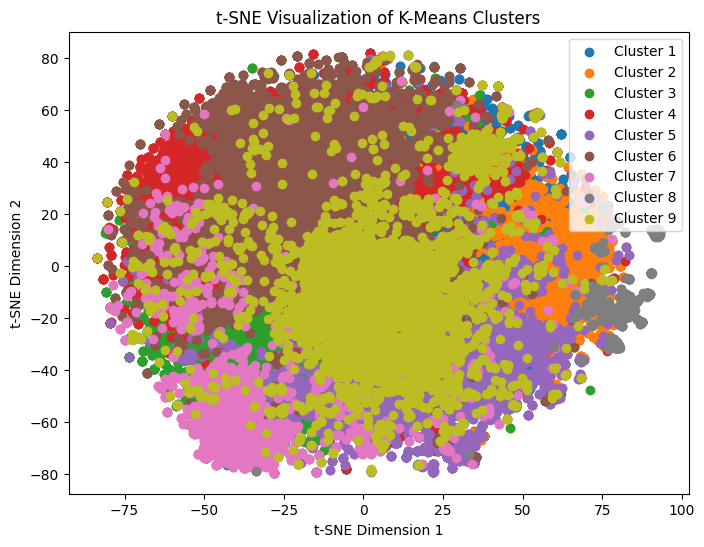

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Get cluster labels
cluster_labels = labels
k = 9
# Apply t-SNE to reduce dimensionality for visualization
tsne = TSNE(n_components=2, random_state=42)
word_embeddings_tsne = tsne.fit_transform(train_embeddings)

# Plot t-SNE visualization with cluster labels
plt.figure(figsize=(8, 6))
for i in range(k):
    plt.scatter(word_embeddings_tsne[cluster_labels == i, 0], 
                word_embeddings_tsne[cluster_labels == i, 1], 
                label=f'Cluster {i+1}')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of K-Means Clusters')
plt.legend()
plt.show()

In [42]:
song = """
It might seem crazy what I am 'bout to say
Sunshine, she's here, you can take a break
I'm a hot air balloon that could go to space
With the air, like I don't care, baby by the way
Huh (Because I'm happy)
Clap along if you feel like a room without a roof
(Because I'm happy)
Clap along if you feel like happiness is the truth
(Because I'm happy)
Clap along if you know what happiness is to you
(Because I'm happy)
Clap along if you feel like that's what you wanna do
Here come bad news talking this and that (Yeah)
Well give me all you got, don't hold back (Yeah)
Well I should probably warn you I'll be just fine (Yeah)
No offense to you don't waste your time
Here's why
Clap along if you feel like a room without a roof
(Because I'm happy)
Clap along if you feel like happiness is the truth
(Because I'm happy)
Clap along if you know what happiness is to you
(Because I'm happy)
Clap along if you feel like that's what you wanna do
Uh, bring me down
Can't nothing, bring me down
My level's too high to bring me down
Can't nothing, bring me down, I said
Bring me down, can't nothing
Bring me down
My level's too high to bring me down
Can't nothing, bring me down, I said
Clap along if you feel like a room without a roof
(Because I'm happy)
Clap along if you feel like happiness is the truth
(Because I'm happy)
Clap along if you know what happiness is to you
(Because I'm happy)
Clap along if you feel like that's what you wanna do
Clap along if you feel like a room without a roof
(Because I'm happy)
Clap along if you feel like happiness is the truth
(Because I'm happy)
Clap along if you know what happiness is to you
(Because I'm happy)
Clap along if you feel like that's what you wanna do
Uh, bring me down (Happy, happy, happy, happy)
Can't nothing (Happy, happy, happy, happy)
Bring me down, my level's too high
To bring me down (Happy, happy, happy, happy)
Can't nothing (Happy, happy, happy, happy)
Bring me down, I said
Clap along if you feel like a room without a roof
(Because I'm happy)
Clap along if you feel like happiness is the truth
(Because I'm happy)
Clap along if you know what happiness is to you (ayy, ayy, ayy)
(Because I'm happy)
Clap along if you feel like that's what you wanna do
Clap along if you feel like a room without a roof
(Because I'm happy)
Clap along if you feel like happiness is the truth
(Because I'm happy)
Clap along if you know what happiness is to you (hey)
(Because I'm happy)
Clap along if you feel like that's what you wanna do
Come on
"""

In [43]:
def predict(lyrics: str, labels: list[str]) -> str:
    song_vector = vectorise(lyrics)[None,:]
    return np.argsort(cosine_distance(X=song_vector ,centroids=centroids))

In [44]:
predict(song,"")

array([[0, 3, 5, 8, 1, 4, 2, 6, 7]], dtype=int64)

In [45]:
centroids

array([[ 0.04296734,  0.03441402,  0.02175763, ..., -0.07365521,
         0.01217681, -0.01384851],
       [ 0.0293246 ,  0.03638233,  0.0303056 , ..., -0.08496177,
        -0.00488135,  0.0116839 ],
       [ 0.05624393,  0.05324594,  0.01895331, ..., -0.04522269,
         0.0297658 , -0.01612653],
       ...,
       [ 0.06941528,  0.04403543,  0.03447174, ..., -0.07939061,
         0.00199658,  0.01946241],
       [ 0.00678938,  0.0428358 ,  0.0542908 , ..., -0.06671903,
        -0.01265312,  0.07285801],
       [ 0.05465438,  0.03869095,  0.02116075, ..., -0.06403305,
         0.01579117, -0.00756458]])

In [46]:
closest_indices_dict = {}
cluster_centers = centroids

# Find the indices of the closest embeddings to each centroid
for i, centroid in enumerate(cluster_centers):
    # Calculate distances between centroid and all embeddings
    distances = cosine_distance(train_embeddings, centroid[None, :])
    # Sort distances and get indices of the closest 5 embeddings
    closest_indices = np.argsort(distances.T)
    # Store indices in dictionary
    closest_indices_dict[f'Centroid {i}'] = closest_indices[0][0]


In [47]:
closest_indices_dict

{'Centroid 0': 54879,
 'Centroid 1': 45718,
 'Centroid 2': 42933,
 'Centroid 3': 41931,
 'Centroid 4': 5072,
 'Centroid 5': 4572,
 'Centroid 6': 34236,
 'Centroid 7': 26223,
 'Centroid 8': 15288}

In [48]:
print(benchmark_df.loc[closest_indices_dict["Centroid 8"]]["text"])

All aboard  
Or are all y'all bored?  
It's good to have y'all back now  
Ladies and gents  
Y'all already know what it is  
God don't make no mistakes  
God don't make no mistakes  
  
Little do they know when I was brought up into this game  
Point ain't always in a vibe for spitting I made a change  
Like the diaper on the bottom of my baby daughter  
I wasn't ready to be no father, maybe, kind of, sorta  
'Cause when I saw her I swear it made a tear fall  
Not tears of sorrow but of joy so listen here y'all  
I grabbed the mic and moved the crowd then disappeared dog  
Back in '94 that was the motherfucking year homeboy  
Then that southernplayalistic went platinum  
Stacks on deck they ain't tell us to pay our taxes  
Walking around the table in the kitchen we was practicing  
Reciting rhymes to sharpen minds now lets deliver to the masses  
  
[Chorus]  
It's been a good long road  
Now its time for me to go  
I say goodbye, goodbye, goodbye, goodbye  
Time to spread my wings  
A

In [50]:
embeddings = np.load("../embeddings/emotions_embeddings_v1.npy")
labels = np.array(
            [
                "Calmness",
                "Sadness",
                "Power",
                "Tension",
                "Amazement",
                "Solemnity",
                "Tenderness",
                "Joyful activation",
                "Nostalgia",
            ])

In [51]:
np.argsort(cosine_distance(centroids, embeddings))

array([[4, 5, 6, 8, 0, 1, 7, 2, 3],
       [7, 2, 3, 4, 5, 6, 8, 0, 1],
       [0, 1, 8, 4, 5, 6, 2, 3, 7],
       [4, 5, 6, 0, 1, 8, 7, 2, 3],
       [0, 1, 4, 5, 6, 8, 7, 2, 3],
       [0, 1, 8, 4, 5, 6, 2, 3, 7],
       [0, 1, 4, 5, 6, 8, 2, 3, 7],
       [7, 2, 3, 4, 5, 6, 0, 1, 8],
       [0, 1, 8, 4, 5, 6, 2, 3, 7]], dtype=int64)

In [52]:
print(benchmark_df.loc[closest_indices_dict["Centroid 8"]]["text"])

All aboard  
Or are all y'all bored?  
It's good to have y'all back now  
Ladies and gents  
Y'all already know what it is  
God don't make no mistakes  
God don't make no mistakes  
  
Little do they know when I was brought up into this game  
Point ain't always in a vibe for spitting I made a change  
Like the diaper on the bottom of my baby daughter  
I wasn't ready to be no father, maybe, kind of, sorta  
'Cause when I saw her I swear it made a tear fall  
Not tears of sorrow but of joy so listen here y'all  
I grabbed the mic and moved the crowd then disappeared dog  
Back in '94 that was the motherfucking year homeboy  
Then that southernplayalistic went platinum  
Stacks on deck they ain't tell us to pay our taxes  
Walking around the table in the kitchen we was practicing  
Reciting rhymes to sharpen minds now lets deliver to the masses  
  
[Chorus]  
It's been a good long road  
Now its time for me to go  
I say goodbye, goodbye, goodbye, goodbye  
Time to spread my wings  
A

In [53]:
mapping = {}
for i, l in enumerate(labels[np.argsort(cosine_distance(centroids, embeddings), axis=1)[:, :4]]):
    mapping[i] = list(l)

In [54]:
mapping

{0: ['Amazement', 'Solemnity', 'Tenderness', 'Nostalgia'],
 1: ['Joyful activation', 'Power', 'Tension', 'Amazement'],
 2: ['Calmness', 'Sadness', 'Nostalgia', 'Amazement'],
 3: ['Amazement', 'Solemnity', 'Tenderness', 'Calmness'],
 4: ['Calmness', 'Sadness', 'Amazement', 'Solemnity'],
 5: ['Calmness', 'Sadness', 'Nostalgia', 'Amazement'],
 6: ['Calmness', 'Sadness', 'Amazement', 'Solemnity'],
 7: ['Joyful activation', 'Power', 'Tension', 'Amazement'],
 8: ['Calmness', 'Sadness', 'Nostalgia', 'Amazement']}

In [55]:
benchmark_df.loc[closest_indices_dict["Centroid 0"]]

artist                                          Vanilla Ice
song                                              I Go Down
link                 /v/vanilla+ice/i+go+down_20143665.html
text      [Verse 1]  \r\nI Remember way back when  \r\nL...
Name: 54879, dtype: object

In [56]:
benchmark_df.loc[closest_indices_dict["Centroid 1"]]

artist                                          Nicki Minaj
song                                     Barbie World Intro
link        /n/nicki+minaj/barbie+world+intro_20873938.html
text      [Chorus:]  \r\nI wanna get to know you  \r\nI ...
Name: 45718, dtype: object

In [57]:
benchmark_df.loc[closest_indices_dict["Centroid 2"]]

artist                                            Marillion
song                                    This Strange Engine
link         /m/marillion/this+strange+engine_20088964.html
text      There was a boy who came into this world  \r\n...
Name: 42933, dtype: object

In [58]:
benchmark_df.loc[closest_indices_dict["Centroid 3"]]

artist                                            LL Cool J
song                                            I Need Love
link                 /l/ll+cool+j/i+need+love_20081043.html
text      When I'm alone in my room  \r\nSometimes I sta...
Name: 41931, dtype: object

In [59]:
benchmark_df.loc[closest_indices_dict["Centroid 4"]]

artist                                               Eminem
song                                         Crack A Bottle
link                 /e/eminem/crack+a+bottle_20775965.html
text      Ladies and gentlemen  \r\nThe moment you've al...
Name: 5072, dtype: object

In [60]:
benchmark_df.loc[closest_indices_dict["Centroid 5"]]

artist                                        Dream Theater
song                                         Space-Dye Vest
link          /d/dream+theater/space+dye+vest_20043326.html
text      Falling through pages of Martens on angels  \r...
Name: 4572, dtype: object

In [61]:
benchmark_df.loc[closest_indices_dict["Centroid 6"]]

artist                                        Gloria Gaynor
song                                           O Holy Night
link            /g/gloria+gaynor/o+holy+night_21073158.html
text      Oh holy night!  \r\nThe stars are brightly shi...
Name: 34236, dtype: object

In [62]:
benchmark_df.loc[closest_indices_dict["Centroid 7"]]

artist                                             Boney M.
song                                        Kalimba De Luna
link               /b/boney+m/kalimba+de+luna_20022442.html
text      In the land of the sunshine  \r\nPeople know h...
Name: 26223, dtype: object

In [63]:
np.save("kmeans_centeroids_v1.npy", centroids)

In [90]:
labels

array([['Amazement', 'Solemnity', 'Tenderness'],
       ['Joyful activation', 'Power', 'Tension'],
       ['Calmness', 'Sadness', 'Nostalgia'],
       ['Amazement', 'Solemnity', 'Tenderness'],
       ['Calmness', 'Sadness', 'Amazement'],
       ['Calmness', 'Sadness', 'Nostalgia'],
       ['Calmness', 'Sadness', 'Amazement'],
       ['Joyful activation', 'Power', 'Tension'],
       ['Calmness', 'Sadness', 'Nostalgia']], dtype='<U17')

In [65]:
d = {}
for i, l in enumerate(labels[np.argsort(cosine_distance(centroids, embeddings), axis=1)[:, :3]]):
    d[i] = list(l)

In [66]:
d

{0: ['Amazement', 'Solemnity', 'Tenderness'],
 1: ['Joyful activation', 'Power', 'Tension'],
 2: ['Calmness', 'Sadness', 'Nostalgia'],
 3: ['Amazement', 'Solemnity', 'Tenderness'],
 4: ['Calmness', 'Sadness', 'Amazement'],
 5: ['Calmness', 'Sadness', 'Nostalgia'],
 6: ['Calmness', 'Sadness', 'Amazement'],
 7: ['Joyful activation', 'Power', 'Tension'],
 8: ['Calmness', 'Sadness', 'Nostalgia']}

In [89]:
cosine_distance(embeddings, embeddings)

array([[ 0.00000000e+00,  0.00000000e+00,  9.04333153e-03,
         9.04333153e-03,  1.57194485e-03,  1.57194485e-03,
         1.57194485e-03,  1.05633683e-02,  5.82928307e-04],
       [ 0.00000000e+00,  0.00000000e+00,  9.04333153e-03,
         9.04333153e-03,  1.57194485e-03,  1.57194485e-03,
         1.57194485e-03,  1.05633683e-02,  5.82928307e-04],
       [ 9.04333153e-03,  9.04333153e-03,  0.00000000e+00,
         0.00000000e+00,  8.64202190e-03,  8.64202190e-03,
         8.64202190e-03,  2.37045506e-03,  7.77378266e-03],
       [ 9.04333153e-03,  9.04333153e-03,  0.00000000e+00,
         0.00000000e+00,  8.64202190e-03,  8.64202190e-03,
         8.64202190e-03,  2.37045506e-03,  7.77378266e-03],
       [ 1.57194485e-03,  1.57194485e-03,  8.64202190e-03,
         8.64202190e-03,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  7.55253225e-03,  1.51644025e-03],
       [ 1.57194485e-03,  1.57194485e-03,  8.64202190e-03,
         8.64202190e-03,  0.00000000e+00,  0.000000

In [ ]:
(['Calmness', 'Sadness', 'Power', 'Tension', 'Amazement', 'Solemnity', 'Tenderness', 'Joyful activation', 'Nostalgia']

In [67]:
dis = cosine_distance(centroids, embeddings)

In [68]:
np.argsort(cosine_distance(centroids, embeddings))

array([[4, 5, 6, 8, 0, 1, 7, 2, 3],
       [7, 2, 3, 4, 5, 6, 8, 0, 1],
       [0, 1, 8, 4, 5, 6, 2, 3, 7],
       [4, 5, 6, 0, 1, 8, 7, 2, 3],
       [0, 1, 4, 5, 6, 8, 7, 2, 3],
       [0, 1, 8, 4, 5, 6, 2, 3, 7],
       [0, 1, 4, 5, 6, 8, 2, 3, 7],
       [7, 2, 3, 4, 5, 6, 0, 1, 8],
       [0, 1, 8, 4, 5, 6, 2, 3, 7]], dtype=int64)

In [69]:
d

{0: ['Amazement', 'Solemnity', 'Tenderness'],
 1: ['Joyful activation', 'Power', 'Tension'],
 2: ['Calmness', 'Sadness', 'Nostalgia'],
 3: ['Amazement', 'Solemnity', 'Tenderness'],
 4: ['Calmness', 'Sadness', 'Amazement'],
 5: ['Calmness', 'Sadness', 'Nostalgia'],
 6: ['Calmness', 'Sadness', 'Amazement'],
 7: ['Joyful activation', 'Power', 'Tension'],
 8: ['Calmness', 'Sadness', 'Nostalgia']}

In [70]:
cosine_distance(centroids, embeddings)[:, :2]

array([[0.00808148, 0.00808148],
       [0.03765219, 0.03765219],
       [0.04187613, 0.04187613],
       [0.03960883, 0.03960883],
       [0.02259843, 0.02259843],
       [0.03396138, 0.03396138],
       [0.07050097, 0.07050097],
       [0.3714057 , 0.3714057 ],
       [0.01754228, 0.01754228]])

In [72]:
benchmark_df.loc[np.argmin(cosine_distance(centroids, train_embeddings), axis=1)]

,artist,song,link,text
54879,Vanilla Ice,I Go Down,/v/vanilla+ice/i+go+down_20143665.html,[Verse 1] \r\nI Remember way back when \r\nL...
45718,Nicki Minaj,Barbie World Intro,/n/nicki+minaj/barbie+world+intro_20873938.html,[Chorus:] \r\nI wanna get to know you \r\nI ...
42933,Marillion,This Strange Engine,/m/marillion/this+strange+engine_20088964.html,There was a boy who came into this world \r\n...
41931,LL Cool J,I Need Love,/l/ll+cool+j/i+need+love_20081043.html,When I'm alone in my room \r\nSometimes I sta...
5072,Eminem,Crack A Bottle,/e/eminem/crack+a+bottle_20775965.html,Ladies and gentlemen \r\nThe moment you've al...
4572,Dream Theater,Space-Dye Vest,/d/dream+theater/space+dye+vest_20043326.html,Falling through pages of Martens on angels \r...
34236,Gloria Gaynor,O Holy Night,/g/gloria+gaynor/o+holy+night_21073158.html,Oh holy night! \r\nThe stars are brightly shi...
26223,Boney M.,Kalimba De Luna,/b/boney+m/kalimba+de+luna_20022442.html,In the land of the sunshine \r\nPeople know h...
15288,Outkast,The Train,/o/outkast/the+train_20482040.html,All aboard \r\nOr are all y'all bored? \r\nI...


In [81]:
labels = np.array(list(d.values()))

In [83]:
predicted_labels = labels[np.argmin(cosine_distance(X=train_embeddings, centroids=centroids), axis=1)]

In [85]:
result = []
for p in predicted_labels:
    result.append(", ".join(p))


In [86]:
benchmark_df["Prediction"] = result

In [87]:
benchmark_df.to_csv("spotify_classification_kmeans.csv")